In [19]:
import logreader as lr
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import tifffile
import glob
from tqdm import tqdm
import numpy as np

In [2]:
#PARAMETERS
animal = '429420_toms'
animal_num = animal.split('_')[0]
date = '20230214'


session_path = Path(f'/ceph/imaging1/arie/{animal}/{date}_{animal_num}')
save_path =  Path(f'/ceph/imaging1/davide/2p_data/{animal}/{date}')

tif_file = glob.glob(str(session_path)+'/*.tif')[0]
log_file = glob.glob(str(session_path)+'/*.b64')[0]

print(log_file)
print(tif_file)

/ceph/imaging1/arie/429420_toms/20230214_429420/20230214-155525_392.b64
/ceph/imaging1/arie/429420_toms/20230214_429420/20230214_429420_00001.tif


# Decode session log and tif header

In [3]:
decoded_log = lr.create_bp_structure(log_file)

Decoding log file


  0%|          | 0/2451540 [00:00<?, ?it/s]

In [4]:
tif_header = lr.read_tif_header(tif_file)

0it [00:00, ?it/s]

In [5]:
frames = tif_header['frame_ts']
i2c_data =tif_header['i2c_data']

In [78]:
def compute_sync_shift(scanner_digital,log_ts,frame_ts):
    '''
    Computes time shift between log timestamps and video timestamps
    PARAMETERS:
    scanner_digital: log digital signal for scanner acquisition events
    start_ts: log timestamps (in us, as read in decoded log file)
    frame_ts: video timestamps (in s, as read from .tif header)

    RETURNS:
    sync_shift: log_ts - frame_ts shift, in seconds
    '''
    #extract indexes of scanner acquisition
    scanner_idxs = np.where(np.diff(scanner_digital.astype(int))==-1)[0]
    #convert indexes to time in seconds
    scanner_ts = log_ts[scanner_idxs]/pow(10,6)
    print(scanner_ts)
    # get rid of spurious signals using inter-signal interval
    scanner_ts = scanner_ts[:-1][np.where(np.diff(scanner_ts)<0.4)]
    # compute mean shift of first 1000 points
    sync_shift = np.mean(scanner_ts[:1000]- frame_ts[:1000])
    return sync_shift

def compute_sync_times(scanner_digital,log_ts,frame_ts):
    '''Computes the the log times in the scanner timeframe '''
    sync_shift = compute_sync_shift(scanner_digital=scanner_digital,log_ts=log_ts,frame_ts=frame_ts)
    times = log_ts/pow(10,6)-sync_shift
    return times

In [82]:
digital_in = decoded_log['digitalIn'].astype(int)
digital_out = decoded_log['digitalOut'].astype(int)
scanner_digital = digital_in[:,6]
log_times = decoded_log['startTS'].astype(float)
barcode = digital_out[:,4]

In [80]:
compute_sync_shift(scanner_digital,log_times,frames)

[  28.733995   28.766995   28.799995 ... 2462.466995 2462.500995
 2462.533995]


28.733614062795002

In [59]:
log_times/pow(10,6)

array([  15.494995,   15.495995,   15.496995, ..., 2467.151995,
       2467.152995, 2467.153995])

In [60]:
compute_sync_times(scanner_digital,log_times,frames)

array([  15466.26138594,   15467.26138594,   15468.26138594, ...,
       2467123.26138594, 2467124.26138594, 2467125.26138594])

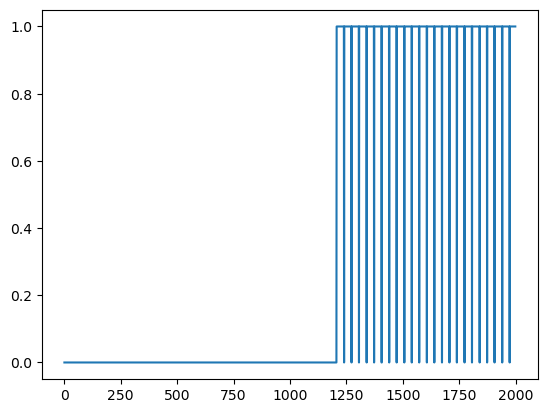

In [61]:
plt.plot(scanner_digital[12000:14000])

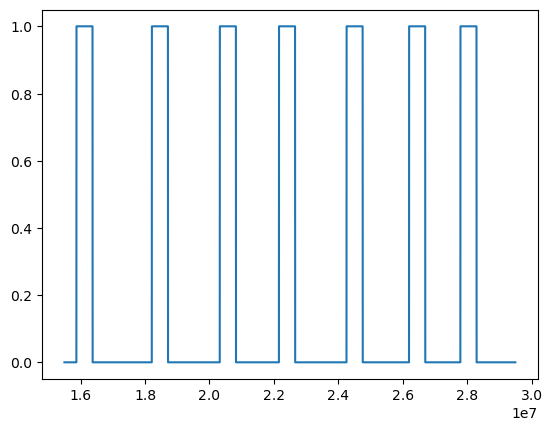

In [89]:
plt.plot(log_times[0:14000],barcode[0:14000])

In [100]:
scanner_ts = log_times[lr.compute_switch(barcode)]/pow(10,6)

In [108]:
timestamps = i2c_data['ts']
values = i2c_data['value']
shift = np.mean(timestamps[-20:]-scanner_ts[-20])
shift

-25.611682837999798

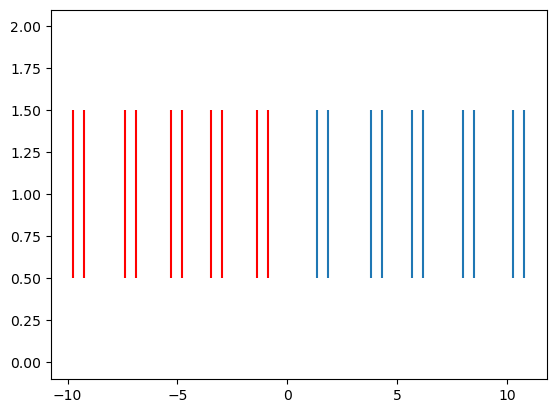

In [109]:
plt.eventplot(timestamps[:10])
plt.eventplot(scanner_ts[:10]+shift,color='r')

# Arrange and plot chanel data

In [297]:
for k in decoded_log.keys():
    print(f'{k}: {decoded_log[k].shape}')

analog: (2903712, 8)
digitalIn: (2903712, 16)
digitalOut: (2903712, 8)
startTS: (2903712,)
transmitTS: (2903712,)
longVar: (2903712, 8)
packetNums: (2903712,)


In [298]:
labels_in = ['empty','empty','wheelA','wheelB','wheelC','IR_camera','scanner','sound','unknown','reward_zone','environment1',
             'environment2','environment3_broken','tunnel1','tunnel2','environment3']
labels_out = ['valve','empty','IR_lED_sync','empty','barcode','IR_LED','lick','empty']

In [299]:
digital_in = decoded_log['digitalIn'].astype(int)
digital_out = decoded_log['digitalOut'].astype(int)
digital_scan_signal = digital_in[:,6]
log_times = decoded_log['startTS']
sync_times = lr.compute_sync_times(digital_scan_signal,log_times,frames)

0
0
0
2903712
40


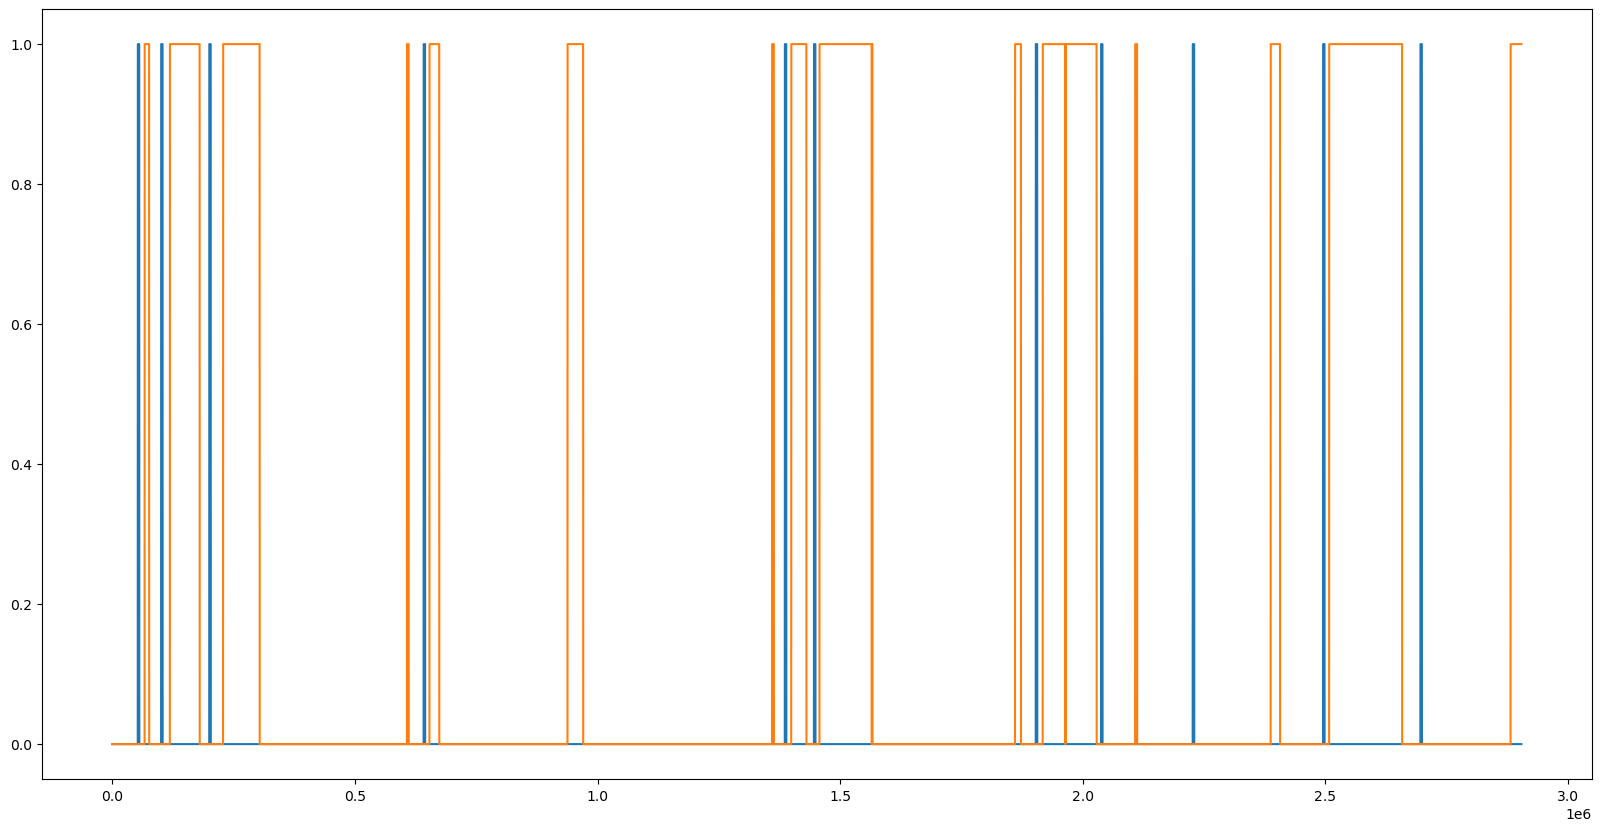

In [300]:
plt.figure(figsize=(20,10))
env1 =invert_polarity(digital_in[:,10])
env2 = digital_in[:,11]
env3 = digital_in[:,-1]

print(sum(env1*env2))
print(sum(env2*env3))
print(sum(env1*env2))
print(len(env1))

#plt.plot(invert_polarity(digital_in[:,10]))
#plt.plot(digital_in[:,11])
plt.plot(digital_in[:,7])
plt.plot(digital_in[:,9])

print(len(onsets))

40


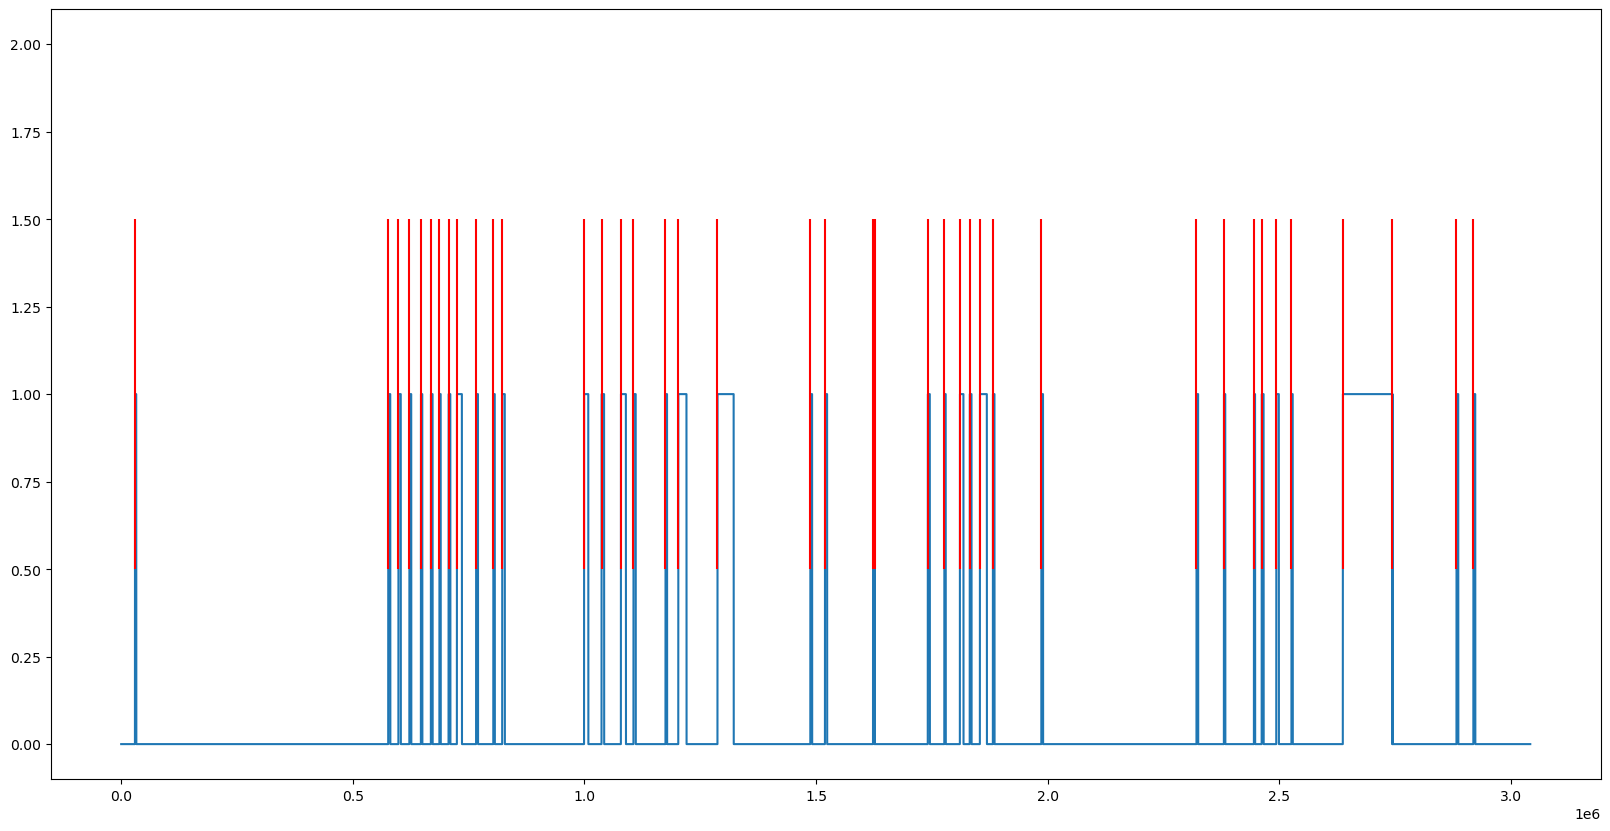

In [244]:
plt.figure(figsize=(20,10))
plt.plot(digital_in[:,9])
onsets = compute_onsets(digital_in[:,9])
plt.eventplot(onsets,color='r')
print(len(onsets))

# Build trial matrix

In [307]:
import numpy as np
import pandas as pd
def invert_polarity(digital_channel):
    '''Inverts channel polarity'''
    digital_channel = np.logical_not(digital_channel).astype(int)
    return digital_channel

def compute_onsets(digital_channel):
    '''Compute transition 0->1 in digital channel'''
    digital_channel = digital_channel.astype(int)
    onsets = np.where(np.diff(digital_channel)==1)[0]+1
    return onsets

def compute_offsets(digital_channel):
    '''Compute transitions 1->0 in digital channel'''
    digital_channel = digital_channel.astype(int)
    onsets = np.where(np.diff(digital_channel)==-1)[0]
    return onsets

def compute_switch(digital_channel):
    '''Compute all transitions in digital channel'''
    digital_channel = digital_channel.astype(int)
    onsets = np.where(np.diff(digital_channel)!=0)[0]
    return onsets


def is_sound(sound_onsets,t1,t2):
    return np.any(np.logical_and((t1<sound_onsets),(t2>sound_onsets)))

def good_reward_zones(reward_onsets,rz_onsets,rz_offsets):
    '''
    checks if there is a reward presentation in the reward zone
    '''
    good_idxs = []
    for i in range(len(rz_offsets)):
        if np.any(np.logical_and((rz_onsets[i]<reward_onsets),(rz_offsets[i]>reward_onsets))):
            good_idxs.append(i)
    return good_idxs


def build_trial_matrix(digital_in,digital_out):
    '''Builds trial matrix from digital channels.

       Trials are defined with reward zones: each reward zone that has a reward in it is used to definie a trial.
       - env_onset is given by the first envinronment channel switch after previous revard zone.
       - tunnel1_onset is given by last environent channel switch before the reward zone of the current trial.
       - reward_zone_onset is given by onset of reward zone in current trial
       - tunnel2_onset is given by offset of reward zone in current trial
       - tunnel2 offset is given by first env switch after current reward zone offset (equals next env_onset by definition)
       - reward_onset is given by first reward onset after reward zone onset
       - reward offset is given by first reward offset reward onset
       - sound onset is given by first sound onset after previous reward zone onset (if present)
       - sound offset is given by first sound offset after sound onset (if present)
    
    '''
    
    # builds trial matrix columns
    trial_matrix = {'env_onset':[],'tunnel1_onset':[],'reward_zone_onset':[],
                    'tunnel2_onset':[],'tunnel2_offset':[],'trial_duration':[],
                    'env_label':[],'sound_onset':[],'sound_offset':[],
                    'sound_presented':[],'reward_onset':[],'reward_offset':[]}

    #columns that need to be converted in timestamps
    timestamp_keys = ['env_onset','tunnel1_onset','reward_zone_onset',
                    'tunnel2_onset','tunnel2_offset','sound_onset','sound_offset',
                    'sound_presented','reward_onset','reward_offset']
    
    #channel mapping
    channels_in = {'env1':10,'env2':11,'env3':15,'sound':7,
                   'tunnel1':13,'tunnel2':14,'reward_zone':9}
    channels_out = {'reward':0}
    
    #extract digital signals
    reward_zone = digital_in[:,channels_in['reward_zone']]
    
    #the first env onsets is always missing, so the channel polarity has to be inverted
    env1 = invert_polarity(digital_in[:,channels_in['env1']])
    env2 = digital_in[:,channels_in['env2']]
    env3 = digital_in[:,channels_in['env3']]
    sound = digital_in[:,channels_in['sound']]
    reward = digital_out[:,channels_out['reward']]

    #compute environment onsets and offsets
    #adds first env1 onset at 0
    env1_switches = np.hstack([np.asarray([0.0]),compute_switch(env1)]) 
    env2_switches = compute_switch(env2)
    env3_switches = compute_switch(env3)
   
    
    #concatenate environments
    env_switches = np.hstack([env1_switches,env2_switches,env3_switches])
  
    #build env labels
    env_labels = np.hstack([np.full_like(env1_switches,1),
                            np.full_like(env2_switches,2),
                            np.full_like(env3_switches,3)])

    #sort envrionments onsets, offsets and labels
    sorted_idxs = np.argsort(env_switches)
    env_switches,env_labels = env_switches[sorted_idxs],env_labels[sorted_idxs]

    #reward zone 
    rz_onsets = compute_onsets(reward_zone)
    rz_offsets = compute_offsets(reward_zone)
    
    #reward presentation
    reward_onsets = compute_onsets(reward)
    reward_offsets = compute_offsets(reward)
    
    good_rz = good_reward_zones(reward_onsets,rz_onsets,rz_offsets)
    
    rz_onsets = rz_onsets[good_rz]
    rz_offsets = rz_offsets[good_rz]
    

    #sound presentation
    sound_onsets = compute_onsets(sound)
    sound_offsets = compute_offsets(sound)
    
    
    #reward presentation
    reward_onsets = compute_onsets(reward)
    reward_offsets = compute_offsets(reward)

    
    
    #first_trial
    trial_matrix['env_onset'].append(env_switches[0])
    trial_matrix['tunnel1_onset'].append(int(np.max(env_switches[env_switches<rz_onsets[0]])))
    trial_matrix['reward_zone_onset'].append(rz_onsets[0])
    trial_matrix['tunnel2_onset'].append(rz_offsets[0])
    trial_matrix['tunnel2_offset'].append(int(np.min(env_switches[env_switches>rz_offsets[0]])))
    
    trial_matrix['trial_duration'].append(np.nan)
    trial_matrix['env_label'].append(int(env_labels[np.argmax(env_switches[env_switches<rz_onsets[0]])]))
    
    if is_sound(sound_onsets,env_switches[0],rz_onsets[0]):
        sound_onset = int(np.min(sound_onsets[sound_onsets>env_switches[0]]))
        sound_offset = int(np.min(sound_offsets[sound_offsets>sound_onset]))
        trial_matrix['sound_onset'].append(sound_onset)
        trial_matrix['sound_offset'].append(sound_offset)
        trial_matrix['sound_presented'].append(True)
    else:
        trial_matrix['sound_onset'].append(np.nan)
        trial_matrix['sound_offset'].append(np.nan)
        trial_matrix['sound_presented'].append(False)
        
    reward_onset = int(np.min(reward_onsets[reward_onsets>rz_onsets[0]]))
    reward_offset = int(np.min(reward_offsets[reward_offsets>reward_onset]))
    trial_matrix['reward_onset'].append(reward_onset)
    trial_matrix['reward_offset'].append(reward_offset)



    #loops reward zones, used for trial definition
    for i in range(1,len(rz_offsets)):
        trial_matrix['env_onset'].append(int(np.min(env_switches[env_switches>rz_offsets[i-1]])))
        trial_matrix['tunnel1_onset'].append(int(np.max(env_switches[env_switches<rz_onsets[i]])))
        trial_matrix['reward_zone_onset'].append(rz_onsets[i])
        trial_matrix['tunnel2_onset'].append(rz_offsets[i])
        
        if len(env_switches[env_switches>rz_offsets[i]])>0: # if the experiment does not end
            trial_matrix['tunnel2_offset'].append(int(np.min(env_switches[env_switches>rz_offsets[i]])))
        else:
            trial_matrix['tunnel2_offset'].append(np.nan)
            
        trial_matrix['trial_duration'].append(np.nan)
        trial_matrix['env_label'].append(int(env_labels[np.argmax(env_switches[env_switches<rz_onsets[i]])]))
        
        if is_sound(sound_onsets,rz_offsets[i-1],rz_onsets[i]):
            sound_onset = int(np.min(sound_onsets[sound_onsets>rz_offsets[i-1]]))
            sound_offset = int(np.min(sound_offsets[sound_offsets>sound_onset]))
            trial_matrix['sound_onset'].append(sound_onset)
            trial_matrix['sound_offset'].append(sound_offset)
            trial_matrix['sound_presented'].append(True)
        else:
            trial_matrix['sound_onset'].append(np.nan)
            trial_matrix['sound_offset'].append(np.nan)
            trial_matrix['sound_presented'].append(False)
            
        reward_onset = int(np.min(reward_onsets[reward_onsets>rz_onsets[i]]))
        reward_offset = int(np.min(reward_offsets[reward_offsets>reward_onset]))
        trial_matrix['reward_onset'].append(reward_onset)
        trial_matrix['reward_offset'].append(reward_offset)


    trial_matrix = pd.DataFrame(trial_matrix)
    
    return trial_matrix

In [308]:
tm = build_trial_matrix(digital_in,digital_out)
tm

,env_onset,tunnel1_onset,reward_zone_onset,tunnel2_onset,tunnel2_offset,trial_duration,env_label,sound_onset,sound_offset,sound_presented,reward_onset,reward_offset
0,0.0,63402,66526,75805,95884,NaN,1,52429.0,55441.0,True,68102,71116
1,95884.0,115457,118560,179884,187844,NaN,3,100524.0,103524.0,True,119267,122266
2,187844.0,225378,228231,303525,308710,NaN,3,199723.0,202738.0,True,228970,231974
3,308710.0,563807,607098,610652,632835,NaN,2,NaN,NaN,False,608066,611066
4,632835.0,650912,653486,673626,676274,NaN,3,641462.0,644464.0,True,654415,657415
5,676274.0,935028,937982,970157,971326,NaN,1,NaN,NaN,False,938695,941703
6,971326.0,1249698,1359456,1363193,1368501,NaN,2,NaN,NaN,False,1360201,1363208
7,1368501.0,1396540,1399041,1430221,1432230,NaN,2,1385766.0,1388769.0,True,1399697,1402702
8,1432230.0,1454231,1457251,1564868,1568600,NaN,3,1445821.0,1448827.0,True,1458048,1461049
9,1568600.0,1857772,1860180,1872362,1879704,NaN,1,NaN,NaN,False,1860920,1863922


In [309]:
def test_trial_matrix(tm,verbose= False):
    '''
    Check that trial matrix satisfies logical conditions.
    '''
    
    correct = True
   
    for i,row in tm.iterrows():
        for column1,column2 in zip(row.index[:3],row.index[1:4]):       
            
            if row[column1]>row[column2]:
                if verbose:
                    print(f'In row {i}: {column1} > {column2}')
                correct = False
                
        if row['sound_onset']< row['env_onset']:
            if verbose:
                print(f'In row {i}: sound_onset < env_onset')    
            correct = False
            
        if row['sound_offset']>row['tunnel1_onset']:
            if verbose:
                print(f'In row {i}: sound_offset > tunnel1_onset')  
            correct = False
    
    return correct

In [310]:
test_trial_matrix(tm)

True

In [169]:
def compute_position(decoded_log,sync_times):
    position = decoded_log['longVar'][:,1]
    return position
def compute_lick_timestamps(decoded_log,sync_times):
    digital_out = decoded_log['digitalOut'].astype(int)
    lick_idxs = lr.compute_onsets(digital_out[:,-2])
    lick_ts = sync_times[lick_idxs]
    return lick_ts


position = compute_position(decoded_log,sync_times)
licks = compute_lick_timestamps(decoded_log,sync_times)
reward = compute_reward_timestamps(decoded_log,sync_times)

data = {'time':sync_times,'position':position.astype('int'),'licks':licks,'reward':reward}

NameError: name 'compute_reward_timestamps' is not defined

In [13]:
position = decoded_log['longVar'][:,1].astype(int)
licks = lr.compute_onsets(digital_out[:,-2]).astype(int)
data = {'position':position,'licks':licks}

In [14]:
len(sync_times)

3187548

In [15]:
len(position)

3187548

In [11]:
#save data
save_path = Path('/scratch/davide/2p_data/429420_toms/20230203_42')

filename = save_path.joinpath('behaviour.pickle')

with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
tm.to_csv(save_path.joinpath('trial_data.csv'))


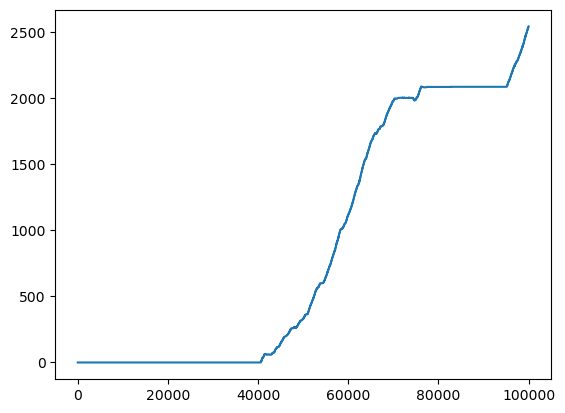

In [56]:
plt.plot(data['position'][:100000])

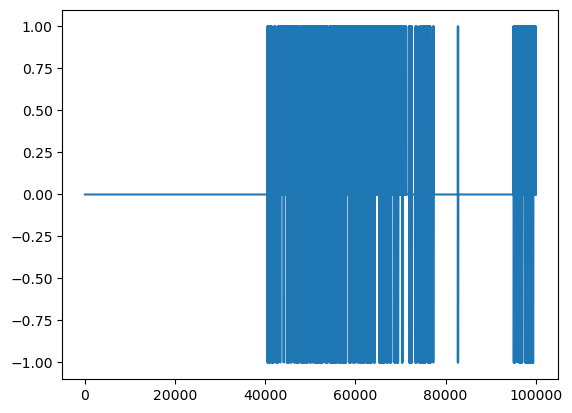

In [57]:
plt.plot(np.diff(data['position'][:100000]))


(0.0, 1000.0)

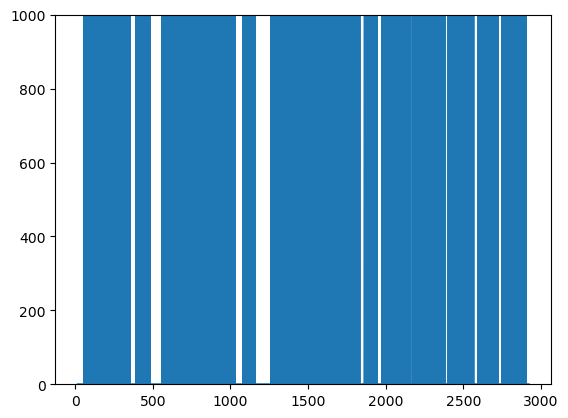

In [30]:
import numpy as np
plt.plot(data['time'][:-1],np.diff(data['position']))
plt.ylim([0,1000])

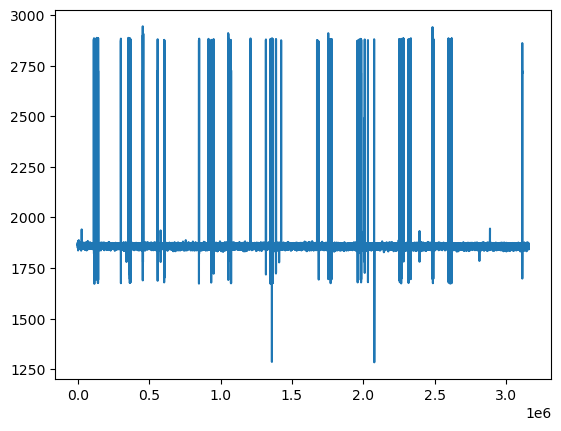

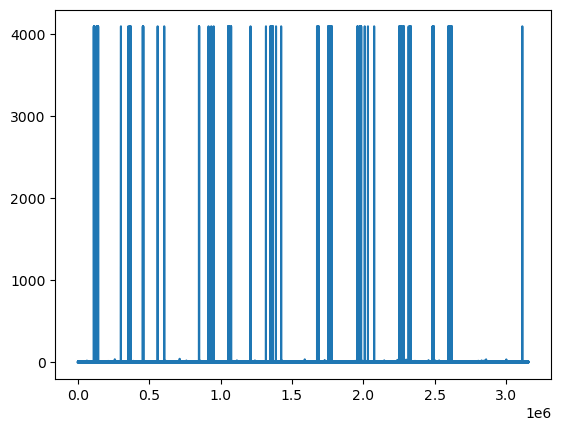

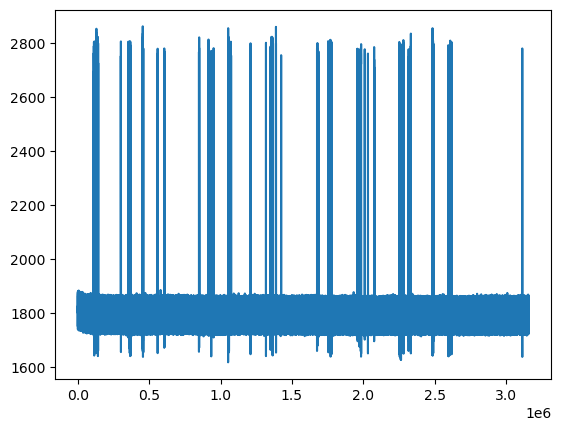

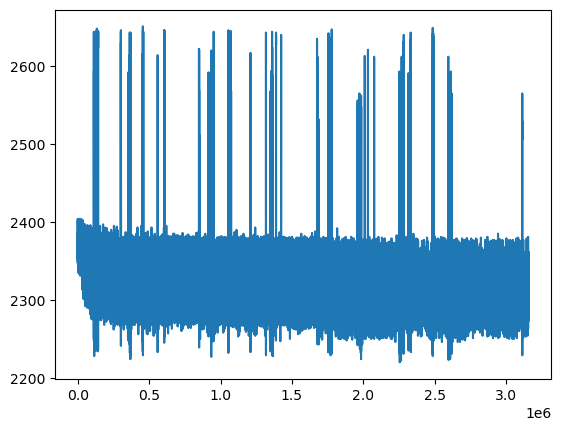

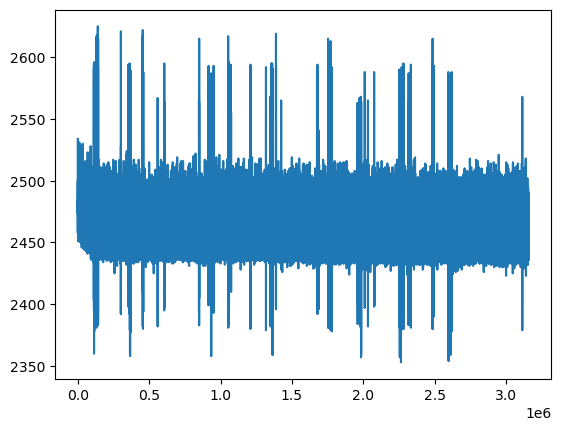

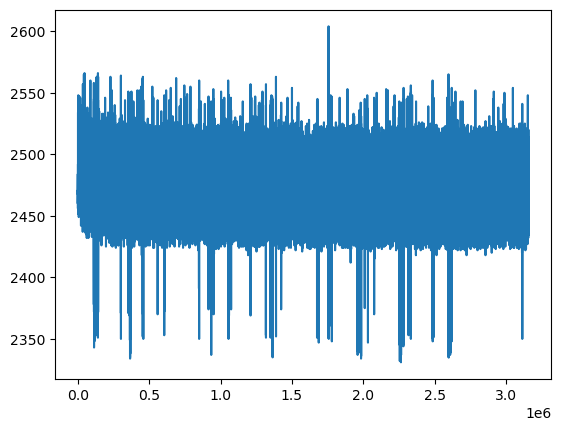

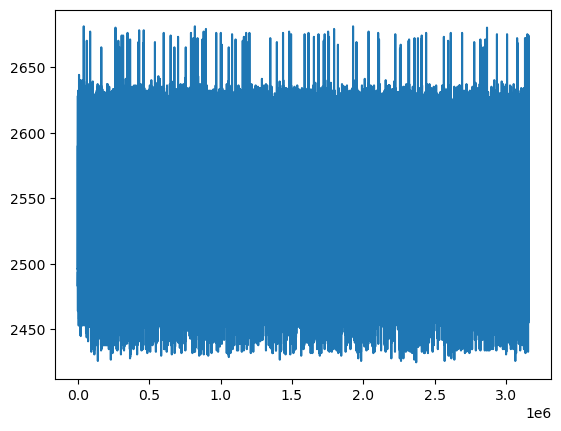

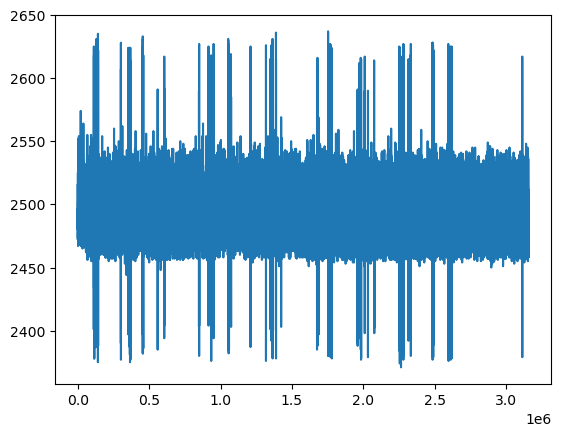

In [319]:
for i,dl in enumerate(decoded_log['analog'].T):
    plt.figure()
    #plt.title(f'{labels_in[i]}')
    plt.plot(dl)